# Your first embedding

## Exercise objectives:

- Run your first RNN for NLP
- Get a first taste of what an embedding is

<hr>

Words are not something you can easily feed to a Neural Network. For this reason, we have to convert them to something more meaningful. 

And this is exactly what _Embeddings_ are for! They map any word onto a vectorial representation (this a fancy way to represent each word with a vector ;) ). For instance, the word `dog` can be represented by the vector $(w_1, w_2, ..., w_n)$ in the embedding space, and we will learn the weights $(w_k)_k$.

So let's just do it.

# The data

❓ **Question** ❓ Let's first load the data. You don't have to understand what is going on in the function, it does not matter here.

⚠️ **Warning** ⚠️ The `load_data` function has a `percentage_of_sentences` argument. Depending on your computer, there are chances that too many sentences will make your compute slow down, or even freeze - your RAM can overflow. For that reason, **you should start with 10% of the sentences** and see if your computer handles it. Otherwise, rerun with a lower number. 

⚠️ **DISCLAIMER** ⚠️ **No need to play _who has the biggest_ (RAM) !** The idea is to get to run your models quickly to prototype. Even in real life, it is recommended that you start with a subset of your data to loop and debug quickly. So increase the number only if you are into getting the best accuracy. 

In [2]:
###########################################
### Just run this cell to load the data ###
###########################################

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)

    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)

        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]

        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]

    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

2025-05-22 14:47:02.514634: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 14:47:02.520502: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 14:47:02.538546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747918022.558805   10816 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747918022.564667   10816 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747918022.581055   10816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Now that you have loaded the data, let's check it out!

❓ **Question** ❓ You can play with the data here. In particular, `X_train` and `X_test` are lists of sentences. Let's print some of them, with their respective label stored in `y_train` and `y_test`.

In [3]:
# Print a few training examples
for i in range(2):
    print(f"Sentence: {X_train[i]}")
    print(f"Label: {y_train[i]}\n")


Sentence: ['this', 'was', 'an', 'absolutely', 'terrible', 'movie', "don't", 'be', 'lured', 'in', 'by', 'christopher', 'walken', 'or', 'michael', 'ironside', 'both', 'are', 'great', 'actors', 'but', 'this', 'must', 'simply', 'be', 'their', 'worst', 'role', 'in', 'history', 'even', 'their', 'great', 'acting', 'could', 'not', 'redeem', 'this', "movie's", 'ridiculous', 'storyline', 'this', 'movie', 'is', 'an', 'early', 'nineties', 'us', 'propaganda', 'piece', 'the', 'most', 'pathetic', 'scenes', 'were', 'those', 'when', 'the', 'columbian', 'rebels', 'were', 'making', 'their', 'cases', 'for', 'revolutions', 'maria', 'conchita', 'alonso', 'appeared', 'phony', 'and', 'her', 'pseudo', 'love', 'affair', 'with', 'walken', 'was', 'nothing', 'but', 'a', 'pathetic', 'emotional', 'plug', 'in', 'a', 'movie', 'that', 'was', 'devoid', 'of', 'any', 'real', 'meaning', 'i', 'am', 'disappointed', 'that', 'there', 'are', 'movies', 'like', 'this', 'ruining', "actor's", 'like', 'christopher', "walken's", 'goo

**LABELS**: the task is a binary classification problem:
- label 0️⃣ corresponds to a <font color=red>negative</font> movie review
- label 1️⃣ corresponds to a <font color=green>positive</font> movie review

**INPUTS**: 
- 🧹 The data has been partially cleaned! So you don't have to worry about it in this exercise. 
- ❗️ But don't forget this step in real-life challenges. 

Remember that words are not computer-compatible materials? You have to tokenize them!

❓ **Question** ❓ Run the following cell to tokenize your sentences

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)

# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

❓ **Question** ❓ Print some of the tokenized sentences to be sure you got what you expected

In [5]:
for i in range(2):
    print(f"Sentence: {X_train_token[i]}")

Sentence: [11, 13, 33, 422, 402, 18, 91, 27, 6893, 8, 31, 1311, 4504, 39, 539, 8007, 194, 24, 75, 161, 17, 11, 228, 336, 27, 68, 252, 203, 8, 468, 58, 68, 75, 108, 98, 21, 4165, 11, 1418, 694, 695, 11, 18, 6, 33, 389, 6065, 204, 2345, 487, 1, 86, 928, 140, 69, 158, 51, 1, 16730, 8008, 69, 251, 68, 2895, 15, 16731, 1877, 12117, 12118, 1344, 4505, 3, 38, 3640, 120, 1386, 16, 4504, 13, 164, 17, 2, 928, 805, 8009, 8, 2, 18, 12, 13, 3231, 4, 99, 142, 1239, 9, 221, 696, 12, 48, 24, 97, 35, 11, 8010, 4506, 35, 1311, 16732, 49, 375, 9, 98, 1006, 753, 137, 10]
Sentence: [9, 25, 76, 572, 5, 730, 1945, 296, 100, 17, 11, 6, 625, 662, 5, 2, 1835, 4, 190, 555, 61, 1170, 115, 2531, 3, 2896, 20, 1, 9585, 3, 264, 40, 5424, 2, 187, 200, 20, 11, 3435, 9, 1387, 1945, 80, 1, 19, 13, 1601, 1, 103, 1056, 13, 2090, 1646, 515, 3, 319, 190, 443, 5, 531, 17, 16, 53, 1878, 4, 46, 13, 4507, 94, 39, 135, 9, 929, 9, 195, 25, 1007, 170, 4, 1, 19, 17, 9, 262, 1, 2532, 4, 10, 3, 273, 40, 443, 5, 531, 4, 96, 181, 9586, 

The dictionary that maps each word to a token can be accessed with `tokenizer.word_index`
    
❓ **Question** ❓ Add a `vocab_size` variable that stores the number of different words (=tokens) in the train set. This is called the _size of the vocabulary_.

In [6]:
# Flatten the list of token lists into a single list of tokens
all_tokens = [token for sentence in X_train for token in sentence]

# Count unique tokens
vocab_size = len(set(all_tokens))
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 30419


Your `X_train_token` and `X_test_token` contain sequences of different lengths.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/NLP/padding.png" alt='Padding example' width="700px" />

However, a neural network has to have a tensor as input. For this reason, you have to pad your data.

❓ **Question** ❓  Pad your data with the `pad_sequences` function (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)). Do not forget about the `dtype` and `padding` keywords (but do not use `maxlen` here).

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the sequences
X_train_padded = pad_sequences(X_train_token, dtype='int32', padding='post')
X_test_padded = pad_sequences(X_test_token, dtype='int32', padding='post')

# Check the shape after padding
print(f"Padded training shape: {X_train_padded.shape}")
print(f"Padded test shape: {X_test_padded.shape}")


Padded training shape: (2500, 1164)
Padded test shape: (2500, 988)


# The RNN

Let's now feed this data to a Recurrent Neural Network.

❓ **Question** ❓ Write a model that has:
- an embedding layer whose `input_dim` is the size of your vocabulary (= your `vocab_size`), and whose `output_dim` is the size of the embedding space you want to have
- a RNN (SimpleRNN, LSTM, GRU) layer
- a Dense layer
- an output layer

⚠️ **Warning** ⚠️ Here, you don't need a masking layer. Why? Because `layers.Embedding` has a argument to do that directly, which you have to set with `mask_zero=True`. That also means that your data **HAS TO** be padded with **0** (which is the default behavior). See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2) to understand how it **impacts** the `input_dim`.

<details>
    <summary>💡 Hint</summary>

`input_dim` should equal size of vocabulary + 1

</details>

Compile it with the appropriate arguments

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import RMSprop

# Define vocabulary size (+1 for padding token = 0)
vocab_size += 1  # Because 0 is reserved for padding

# Define embedding dimension
embedding_dim = 64  # You can tune this value (e.g., 32, 64, 128)

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
    SimpleRNN(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # or 'softmax' for multi-class
])

# Compile the model
model.compile(
    optimizer=RMSprop(),
    loss='binary_crossentropy',  # or 'sparse_categorical_crossentropy' for multi-class
    metrics=['accuracy']
)


In [9]:
sequence_length = X_train_padded.shape[1]  # Get the length of padded sequences

model.build(input_shape=(None, vocab_size))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30420, 64)      │     1,946,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,957,249 (7.47 MB)

 Trainable params: 1,957,249 (7.47 MB)

 Non-trainable params: 0 (0.00 B)

❓ Double-check that the number of parameters in your embedding layer is equal to the (number of words in your vocabulary + 1 for the masking value) $\times$  the dimension of your embedding.

❓ **Question** ❓ Start fitting your model with 20 epochs, with an early stopping criterion whose patience is equal to 4.

⚠️ **Warning** ⚠️ You might see that it takes a lot of time! 

**So stop it after a couple of iterations!**

In [10]:
# YOUR CODE HERE

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
# Set early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=4,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/4
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 614ms/step - accuracy: 0.4883 - loss: 0.7043 - val_accuracy: 0.5120 - val_loss: 0.6916
Epoch 2/4
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 559ms/step - accuracy: 0.5601 - loss: 0.6838 - val_accuracy: 0.5240 - val_loss: 0.6884
Epoch 3/4
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 547ms/step - accuracy: 0.6506 - loss: 0.6442 - val_accuracy: 0.5800 - val_loss: 0.6645
Epoch 4/4
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 555ms/step - accuracy: 0.8906 - loss: 0.3598 - val_accuracy: 0.6020 - val_loss: 0.7571


Let's not waste too much time just staring at our screen or having coffees. It is too early to start having breaks ;)

❓ **Question** ❓ We will reduce the computational time. To start, let's first look at how many words there are in the different sentences of your train set (Just run the following cell).

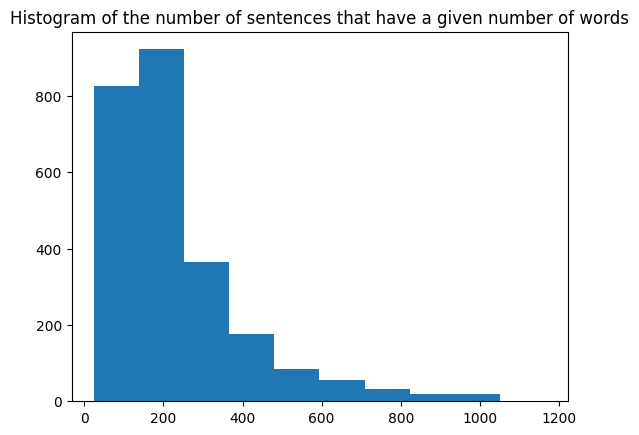

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()

plot_hist(X_train)


You will probably see that 90 to 95% of your sentences have less than 300 words. And very few have more than 1000.

However, as you didn't use `maxlen` in your padding above, your input tensor has a dimension equal to the length of the sentence that has the maximum number of words.

Now, let's look at how this affects the padding: 


<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/NLP/tensor_size.png" alt='Dimensions of the tensor' width="700px" />

Because of a few of very long sentences, one dimension of your tensor is equal to around 1000. However, most of the sentences with ~200 words have just padded values that are useless.

So your tensor is mostly useless information, which still adds time to the training process.

But what if you pad the data to a maximum length (`maxlen`) of say 200 (words)?
- First, that would increase the convergence and you would not need to stare at your screen while waiting for the algorithm to converge
- But in essence, do you really lose that much information? Do you think that you often need more than 200 words (up to 1000) to tell whether or not a sentence is positive of negative?

❓ **Question** ❓ For all these reasons, re-do your padding using the `maxlen` keyword and retrain the model!  See how much faster it is now - without hurting the performance ;)

In [14]:


X_train_padded = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=200)
X_test_padded = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=200)

print(f"Padded training shape: {X_train_padded.shape}")
print(f"Padded test shape: {X_test_padded.shape}")


Padded training shape: (2500, 200)
Padded test shape: (2500, 200)


In [15]:
# Train model
history = model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8918 - loss: 0.3586 - val_accuracy: 0.6040 - val_loss: 0.7555
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9860 - loss: 0.0821 - val_accuracy: 0.6180 - val_loss: 0.9497
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9916 - loss: 0.0298 - val_accuracy: 0.5940 - val_loss: 1.1327
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.6120 - val_loss: 1.2799
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9921 - loss: 0.0290 - val_accuracy: 0.5500 - val_loss: 1.3497


🏁 Nice, you are now able to use `Tokenizer` and `pad_sequences`

💾 Don't forget to git add/commit/push your notebook...

🚀 ... and move on to the next challenge!